## Processo de decisão

Criando um workflow mais complexo utilizando `conditional_edges`.

## Setup

In [15]:
from typing import Literal, TypedDict

from dotenv import find_dotenv, load_dotenv
from duckduckgo_search import DDGS
from IPython.display import display, Image
from langgraph.graph import END, StateGraph, START
from langgraph.pregel import RetryPolicy
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

In [2]:
_ = load_dotenv(find_dotenv('.env'))

In [10]:
client = ChatOpenAI(model='gpt-3.5-turbo', temperature=0.3)

## State

In [6]:
class State(TypedDict):
    question: str
    content: str
    response: str

## Callback

In [30]:
def classification(state: State) -> Literal['search', 'llm']:
    prompt = ChatPromptTemplate.from_template(
        """O seu papel é classificar a necessidade do usuário, é necessário fazer uma pesquisa na internet ou utilizar um llm diretamente.

Classifique em:
    - search
    - llm

Pergunta: {question}"""
    )
    chain = prompt | client | StrOutputParser()
    response = chain.invoke({'question': state['question']})

    print('Classificação:', response)
    if response == 'search':
        return 'search'

    return 'llm'


def search(state: State) -> State:
    q = state['question']
    print('Pesquisando no DDG:', q)
    with DDGS() as ddgs:
        results = ddgs.text(q, max_results=1)

    if results:
        content = '\n'.join([r['body'] for r in results if 'body' in r])
    else:
        content = 'Nenhum resultado encontrato'

    return {'content': content}


def llm(state: State) -> State:
    print('Resposta direta do LLM')
    prompt = ChatPromptTemplate.from_template(
        'Responda a seguinte pergunta: {question}'
    )
    chain = prompt | client
    response = chain.invoke({'question': state['question']})

    return {'response': response.content}


def synthesize(state: State) -> State:
    content = state.get('content', '')
    q = state['question']
    prompt = ChatPromptTemplate.from_template(
        """Use o seguinte contexto para responder a pergunta:
Contexto: {content}
Pergunta: {question}
Resposta:"""
    )
    chain = prompt | client
    response = chain.invoke({'content': content, 'question': q})
    print('Resposta gerada')

    return {'response': response.content}

## Grafo

In [31]:
builder = StateGraph(State)
builder.add_node('search', search)
builder.add_node('llm', llm)
builder.add_node('synthesize', synthesize)

builder.add_conditional_edges(START, classification)
builder.add_edge('llm', END)
builder.add_edge('search', 'synthesize')
builder.add_edge('synthesize', END)

graph = builder.compile()

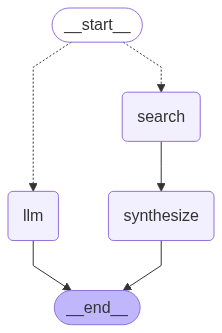

In [38]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke

In [32]:
graph.invoke({'question': 'Qual é a capital da Alemanha?'})

Classificação: search
Pesquisando no DDG: Qual é a capital da Alemanha?
Resposta gerada


{'question': 'Qual é a capital da Alemanha?',
 'content': 'Berlim (em alemão: Berlin, AFI: [bɛʁˈliːn], ouvir ⓘ) é a capital e um dos dezesseis estados da Alemanha.Com uma população de 3,5 milhões dentro de limites da cidade, é a maior cidade do país, e a sétima área urbana mais povoada da União Europeia. [4] Situada no nordeste da Alemanha, é o centro da área metropolitana de Berlim-Brandemburgo, que inclui 5 milhões de pessoas de ...',
 'response': 'A capital da Alemanha é Berlim.'}

In [34]:
graph.invoke(
    {'question': 'Sem pesquisar na internet. Qual a capital da Alemanha?'}
)

Classificação: llm
Resposta direta do LLM


{'question': 'Sem pesquisar na internet. Qual a capital da Alemanha?',
 'response': 'A capital da Alemanha é Berlim.'}